Generates data using factor models with 2 factors and a time-varying factor loadings based on step functions and residuals from i.i.d multivariate normal distribution with an identity matrix as its covariance matrix.

In [ ]:
import numpy as np
import pandas as pd

def generate_sample_setting1(p, T, D, seed=1234):
    """Generates a time-varying sample based on factor models with 2 factors and a step function for factor loadings.

    Args:
      p: Dimension of the portfolio.
      T: Sample size.
      D: The length of each step in the factor loadings.

    Returns:
      A (p, T) matrix of asset returns.
    """

    #Seed for reproducibility
    np.random.seed(seed)

    # Number of steps, common factor intercepts
    k = T // D
    muf1 = 0 # Intercept (mean) term for factor 1
    muf2 = 0 # Intercept (mean) term for factor 2

    # Common factors initialization
    f1 = np.zeros(T)  # Factor 1, initialized to zeros
    f2 = np.zeros(T)  # Factor 2, initialized to zeros

    # Generate common factors f1 and f2
    for t in range(1, T):
        # Random disturbances for each factor
        u1_t = np.random.normal(0, np.sqrt(1 - 0.6 ** 2))
        u2_t = np.random.normal(0, np.sqrt(1 - 0.3 ** 2))

        # Update factors with their respective equations
        f1[t] = muf1 + 0.6 * f1[t-1] + u1_t
        f2[t] = muf2 + 0.3 * f2[t-1] + u2_t

    # Stack common factors into matrix for convenience
    F_t = np.vstack([f1, f2])

    # Initialize factor loadings with zeros
    loadings = np.zeros((p, 2, T))

    # Generate factor loadings based on given step function
    for i in range(p):
        # Standard normal random variables for each step
        zi = np.abs(np.random.normal(0, 1, k))
        vi = np.abs(np.random.normal(0, 1, k))

        # Compute factor loadings according to step function
        for t in range(T):
            step = t // D
            loadings[i, 0, t] = 2 * zi[0] + sum(zi[1:step + 1])
            loadings[i, 1, t] = 2 * vi[0] + sum(vi[1:step + 1])

    # Assign the computed loadings
    b_it = loadings

    # Initialize returns matrix
    returns = np.zeros((p, T))

    # Generate returns for each variable and time period
    for t in range(T):
        # Error term from multivariate normal distribution
        e_it = np.random.multivariate_normal(np.zeros(p), np.identity(p))

        for i in range(p):
            # Combine the common factors, factor loadings, and error terms to generate the sample.
            returns[i, t] = b_it[i, :, t].dot(F_t[:, t]) + e_it[i]

    # Create a DataFrame
    returns_df = pd.DataFrame(returns.T, columns=[f'Series_{i+1}' for i in range(p)])

    return returns_df

In [ ]:
# Example usage with specific values for p, T, and D
p = 50
T = 250
D = 25
returns = generate_sample_setting1(p, T, D)
returns.head(3)

,Series_1,Series_2,Series_3,Series_4,Series_5,Series_6,Series_7,Series_8,Series_9,Series_10,...,Series_41,Series_42,Series_43,Series_44,Series_45,Series_46,Series_47,Series_48,Series_49,Series_50
0,-0.615561,0.385286,0.291495,-0.224159,1.089270,1.011388,1.124646,-1.870844,0.175739,-0.776586,...,-0.353355,1.553044,0.075131,0.995823,-0.122947,1.000219,-0.410987,0.172256,0.844084,1.176347
1,1.300216,-2.256708,-1.990634,-4.271430,-1.476677,-1.340750,0.590480,-2.052232,-1.619129,2.444833,...,-0.587461,-1.430870,-1.268531,-1.778864,-0.415790,-2.035249,-0.705692,-0.388768,-1.165720,0.030521
2,3.942625,2.625089,-0.397897,-0.999993,2.058781,3.252197,4.316034,0.843886,3.091304,2.787020,...,3.070097,3.295825,0.005945,0.569147,2.695901,-0.692361,0.109677,1.920670,-1.220236,5.552513


<Axes: >

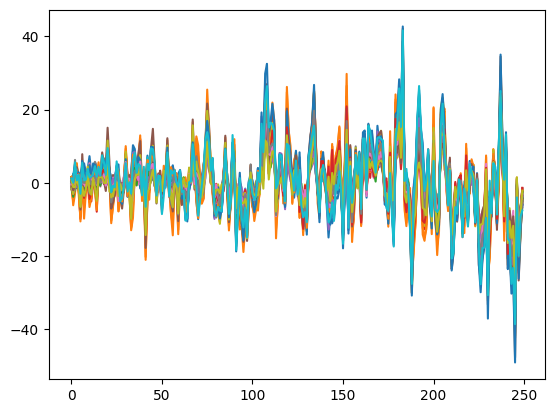

In [ ]:
returns.plot(legend = False)